In [188]:
import math
import yaml, os, argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from skimage.color import hsv2rgb
import cv2
from collections import deque
from scipy.special import softmax


class Mooveemodel:
    def __init__(self, x_init, y_init, mu_s, sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity):
        self.mu = np.array([mu_s,0.])
        self.theta = np.array([theta_speed,theta_angular_velocity])
        self.sigma = np.array([sigma_speed,sigma_angular_velocity])
        self.v = np.array(self.mu)
        self.dt = np.ones(2)
        self.rng = np.random.default_rng()
        self.pos = np.array([x_init,y_init])
        self.angle = 0.
        self.os = np.array(self.mu)
        self.s = 0
        self.updateSpeed()

    def updateSpeed(self):
        os1 = self.os
        mu1 = self.mu
        theta1 = self.theta
        dt1 = self.dt
        sigma1 = self.sigma
        rng1 = self.rng
        
        self.os = (os1
            + theta1 * (mu1 - os1) * dt1
            + sigma1 * rng1.normal(0,np.sqrt(dt1),2)
        )
        
        self.angle = self.angle + self.os[1] * dt1[1]
        
        self.s = np.log1p(np.exp(self.os[0]))
        self.v[0] = self.s*np.cos(self.angle)
        self.v[1] = self.s*np.sin(self.angle)
        #self.v[0] = abs(self.os[0])*np.cos(self.angle)
        #self.v[1] = abs(self.os[0])*np.sin(self.angle)

        return self.v

    def updatePosition(self, side):
        new_pos = self.pos + self.v * self.dt
        self.pos = new_pos % side
        is_same_panel = True if np.all(new_pos == self.pos) else False
        return self.pos, is_same_panel

    def getDirection(self):
        return np.degrees(np.arctan2(self.v[1],self.v[0]))



In [248]:
mu_s ,sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity, name = 4, 4, 0, 0.1, 0, 'straight line, OU speed process'
mu_s ,sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity, name = 10, 0, 0, 0, 0, 'continuous speed movement in a straight line'
mu_s ,sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity, name = 4, 4, 1, 0.1, 0.5, 'OU process A'
mu_s ,sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity, name = 7, 4, 1, 0.1, 0.3, 'OU process B'
mu_s ,sigma_speed, sigma_angular_velocity, theta_speed, theta_angular_velocity, name = 10, 0.1, 0.1, 0, 0.5, 'slow acceleration OU'

mm = Mooveemodel(0,0, mu_s, sigma_speed,sigma_angular_velocity,theta_speed, theta_angular_velocity)


In [249]:
speeds_a = []
speeds_b = []
speeds_c = []
angles = []
speeds_mag = []

for _ in range(10000):
    a = mm.v[0]
    b = mm.v[1]
    c = mm.os[0] #speed
    aa = mm.angle
    speeds_a.append(a)
    speeds_b.append(b)
    speeds_c.append(c)
    angles.append(aa)
    speeds_mag.append(mm.s)
    mm.updateSpeed()


Speed: sigma=0.1, theta=0
Angular velocity: sigma=0.1, theta=0.5


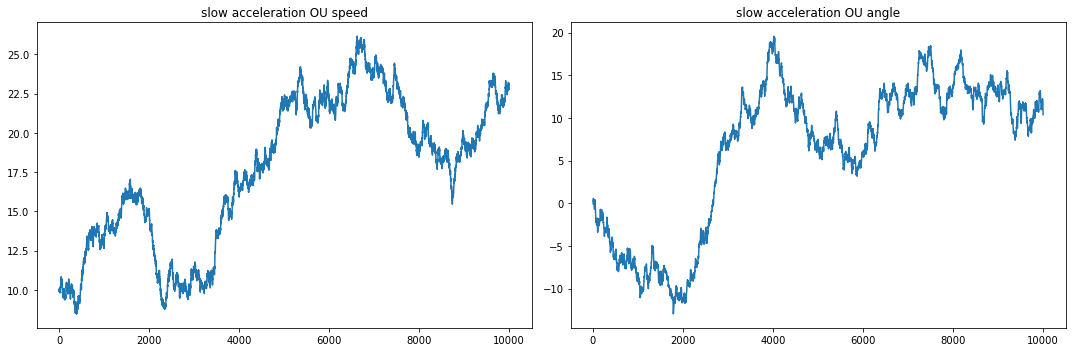

In [250]:
f, ax = plt.subplots(1,2, figsize=(15,5))
polots = ax.flatten()
polots[0].plot(speeds_mag)
polots[0].set_title(name + " speed")
polots[1].plot(angles)
polots[1].set_title(name + " angle")
f.tight_layout()
s_str = 'Speed: sigma={0}, theta={1}'.format(sigma_speed,theta_speed)
a_str = 'Angular velocity: sigma={0}, theta={1}'.format(sigma_angular_velocity,theta_angular_velocity)
print(s_str)
print(a_str)